In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

## DEFINITIONS

### Trade-offs

In [2]:
def R_fun(s,e=1,s_max=1,Rmin=0.9,Rmax=0.99):
    r=Rmax+(Rmin-Rmax)*(s/s_max)/(e-(e-1)*(s/s_max))
    return(r)

def e_log(a,e=1,a_min=1e-12,a_max=1e-5,e_min=0.9,e_max=0.99):
    a=a_max*(np.log10(a)-np.log10(a_min))/(np.log10(a_max)-np.log10(a_min))
    epsilon=e_max+(e_min-e_max)*(a/a_max)/(e-(e-1)*(a/a_max))
    return(epsilon)

### Stress

In [4]:
def construction_stress_periodic_1(T,dt,d1,d2,i_min,i_max):
    # d1: stress duration
    # d2: no stress duration
    # i_min, i_max: min and max stress intensities
    
    stress=np.array([])
    
    while np.size(stress)<=int(T/dt):
        stress=np.concatenate((stress,np.zeros(int(d2/dt)),np.repeat(np.random.uniform(i_min,i_max),int(d1/dt))))
    
    return stress[:(int(T/dt)+1)]

### Model

In [6]:
def replication(B,dt,r):
    # dt: time step
    # r: replication rate

    G=np.random.binomial(B,r*dt)
    return G

def lyse_stress(B,dt,t,d,s):
    # dt: time step
    # d: death rate
    # s: resistance rate
    
    N=np.reshape(np.sum(B,1),(nb_community,-1))
    L=np.random.binomial(B,(N*d+f2(t,s))*dt)
    return L

def infection(B,dt,a):
    # dt: time step
    # a: plasmid horizontal transfer rate
    
    I=np.random.binomial(np.reshape(B[:,0],(nb_community,-1)),B[:,1:]*a*dt)
    return I

def transfert_vertical(B,e):
    # dt: time step
    # e: plasmid vertical transfer rate

    D=np.random.binomial(B,e)
    return D

def innovation(B,dt,i):
    # dt: time step
    # i: innovation rate 
    
    N=np.random.binomial(B,i*dt)
    return N

def dispersion(B,dt,g): 
    # dt: time step
    
    D=np.random.binomial(B,g*dt)    
    return D

In [40]:
def mges_incompatibles_stochastique(B0,dt,T,n,r,e,d,a,s,i,g):
    # dt: time step
    # T: final time
    # t0: initial time
    # n: number of community
    # r: vector of replication rate
    # e: vertical transfer probability
    # d: competition coefficient
    # a: vector of infection rate
    # s: vector of resistance rate
    # i: rate of mutation
    # g: diseprsion matrix
    
    nb_species_init=np.shape(B0)[1]
    
    for t in range(int(T/dt)):
        B0=np.int64(B0)
        B0=np.maximum(B0,0)
        B=B0
        for c1 in range(n):
            for c2 in range(c1+1,n):
                #if c2!=c1:
                G1_2=dispersion(B0[c1,:],dt,g[c1,c2])
                G2_1=dispersion(B0[c2,:],dt,g[c2,c1])
                B[c1,:]=B[c1,:]+G2_1-G1_2
                B[c2,:]=B[c2,:]+G1_2-G2_1
        
        # Local processes
        R=replication(B,dt,r)
        RP=transfert_vertical(R[:,1:],e)
        RNP=R[:,1:]-RP
        L=lyse_stress(B,dt,t,d,s)
        I=infection(B,dt,a)

        B[:,1:]=B[:,1:]+RP-L[:,1:]+I
        B[:,0]=B[:,0]+R[:,0]-L[:,0]-np.sum(I,1)+np.sum(RNP,1)
        
        # Innovation
        N=innovation(B[:,1:],dt,i)
        N_sum=np.sum(N>0)
        if(N_sum>0):
            N_ind_community=np.where(N>0)[0]
            N_ind_mge=np.where(N>0)[1]
            a_new=np.random.normal(np.log10(a[N_ind_mge]),0.1,N_sum)
            a_new=np.minimum(a_new,-5)
            a_new=np.maximum(a_new,-12)
            a_new=10**a_new
            s_new=np.random.normal(s[N_ind_mge-1],0.05,N_sum)
            s_new=np.minimum(s_new,1)
            s_new=np.maximum(s_new,0)
            a=np.append(a,a_new)
            s=np.append(s,s_new)
            r_new=R_fun(s_new,1)
            e_new=e_log(a_new,1)
            r=np.append(r,r_new)
            e=np.append(e,e_new)
            B[:,1:]=B[:,1:]-N
            B_new=np.zeros((nb_community,N_sum))
            N_ind=np.where(N>0)
            for j in range(N_sum):
                tmp=N_ind[0][j]
                B_new[tmp,j]=1
            B=np.append(B,B_new,axis=1)
        B=np.maximum(B,0)
        # Extinction
        B_ind=np.all(B[:,1:]==0,axis=0)
        if np.sum(B_ind)>0:
            tmp=np.where(B_ind==1)[0]+1
            B=np.delete(B,tmp,axis=-1)
            r=np.delete(r,tmp)
            s=np.delete(s,tmp)
            a=np.delete(a,tmp-1)
            e=np.delete(e,tmp-1)
        B0=B

    return(B,a,s)

## TEMPORAL PLASMID ASSEMBLY

### t=0

In [8]:
np.random.seed(42)

nb_mges=200
nb_replicats=4
nb_community=nb_replicats*3
T=1000
dt=0.1

d=1e-6
a=[]
s=[]
S=np.zeros((nb_community,int(T/dt)+1))
for i in range(nb_replicats):
    S[i,:]=construction_stress_periodic_1(1000,0.1,95,5,0.9,0.9)
    S[i+nb_replicats,:]=construction_stress_periodic_1(1000,0.1,5,95,0.9,0.9)
    S[i+2*nb_replicats,:]=construction_stress_periodic_1(1000,0.1,50,50,0.9,0.9)

s=np.random.uniform(0.2,0.8,nb_mges)
a=10**(np.random.uniform(-11,-6,nb_mges))

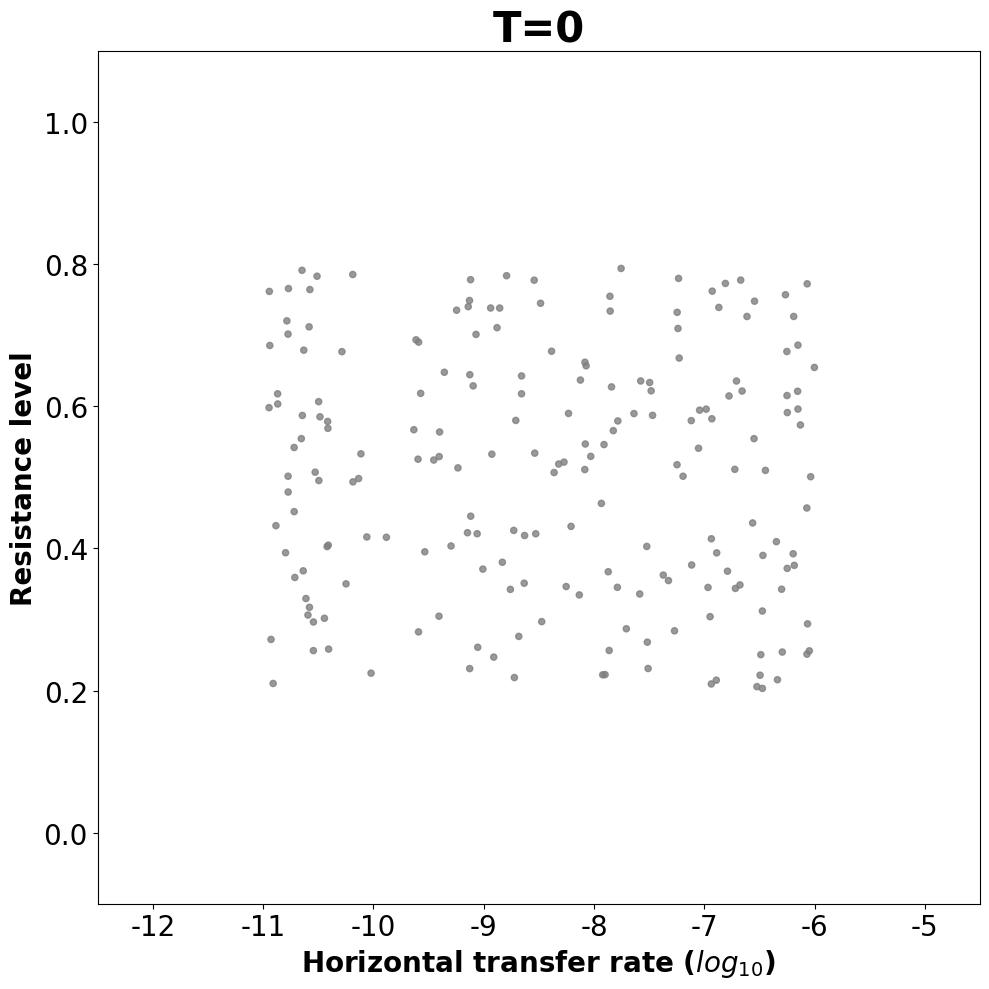

In [9]:
xticks=np.arange(-12,-4,1)
yticks=np.round(np.arange(0,1.1,0.2),1)
run=np.repeat(1,nb_mges)
init={'a_init':np.log10(a),'s_init':s,'density_init':np.repeat(20,nb_mges)}
init_df=pd.DataFrame(data=init)

############################## FIGURES
fig, axs = plt.subplots(1,1,figsize=(10,10),sharex=True,sharey=True)

scatter=axs.scatter(data=init_df, x="a_init", y="s_init", s="density_init",alpha=0.8,c="grey")
axs.set_xlabel("Horizontal transfer rate ($log_{10}$)",size=20,weight="bold")
axs.set_ylabel("Resistance level", size=20,weight="bold")
axs.set_title("T=0",size=30,weight="bold")

axs.set_xlim(-12.5,-4.5)
axs.set_ylim(-0.1,1.1)
axs.set_xticks(xticks)
axs.set_xticklabels(xticks,rotation=0,size=20)
axs.set_yticks(yticks)
axs.set_yticklabels(yticks,rotation=0,size=20)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

### t=100

In [10]:
def f2(t,s):
    return np.reshape(S[:,t],(nb_community,-1))*(1-s)


T=100
dt=0.1
s_bis=np.concatenate(([0],s))
r=R_fun(s,1)
r_bis=np.concatenate(([1],r))
e=e_log(a,1)


g=1e-9*np.ones((nb_community,nb_community))
B0=np.zeros((nb_community,nb_mges+1))
B0[:,0]=1000
B0[:,1:]=10
for i in range(nb_community):
    g[i,i]=0

B,a_res,s_res=mges_incompatibles_stochastique(B0,dt,T,nb_community,r_bis,e,d,a,s_bis,1e-4,g)
print(np.shape(B))

(12, 1520)


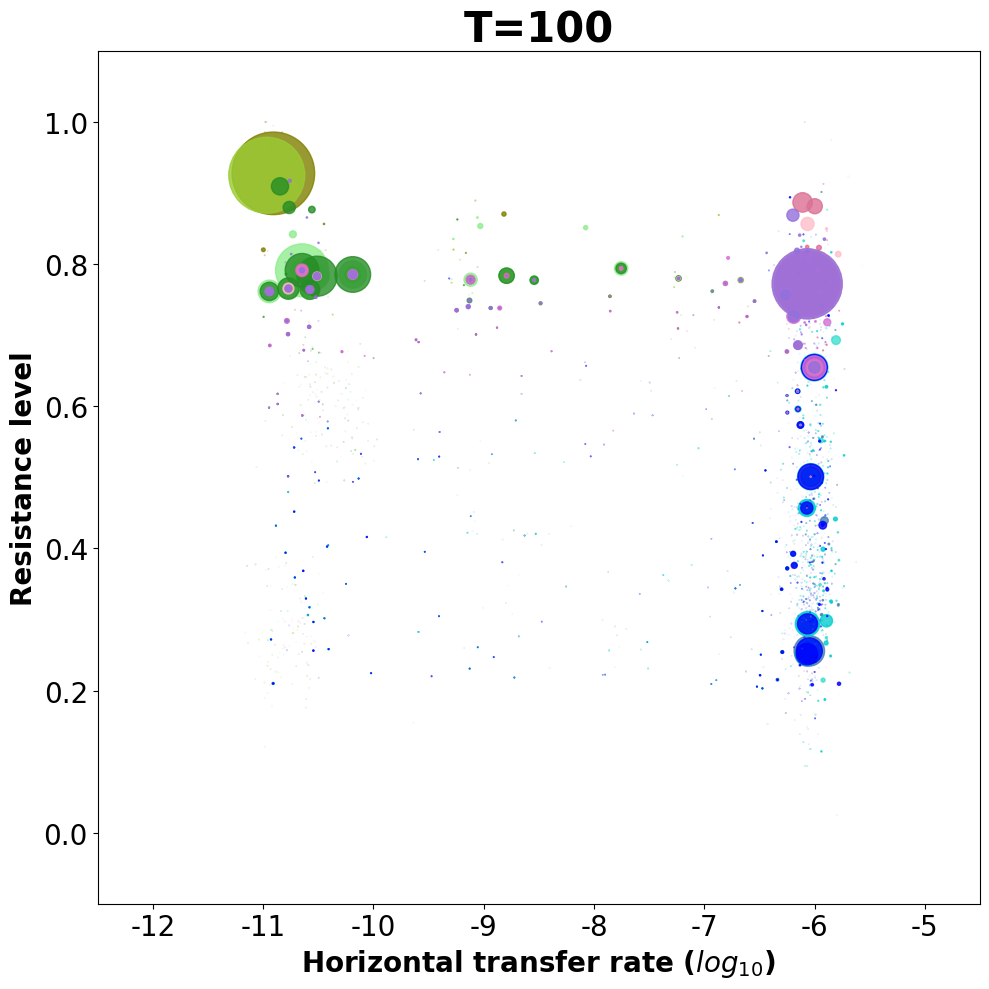

In [13]:
xticks=np.arange(-12,-4,1)
yticks=np.round(np.arange(0,1.1,0.2),1)
color=LinearSegmentedColormap.from_list("",["olive","yellowgreen","lightgreen","forestgreen","turquoise","steelblue","darkturquoise","blue","pink","palevioletred","orchid","mediumpurple"])
nb_mges_final=np.shape(B)[1]-1

norm=200
run=np.repeat(np.arange(1,nb_community+1),nb_mges_final)
a_tot=np.log10(np.tile(a_res,nb_community))
s_tot=np.tile(s_res[1:],nb_community)
mge_1d=np.reshape(B[:,1:],-1,order='C')

res={'run':run,'a_tot':a_tot,'s_tot':s_tot,'density_final':mge_1d/norm}
res_df = pd.DataFrame(data=res)

############################## FIGURES
fig, axs = plt.subplots(1,1,figsize=(10,10),sharex=True,sharey=True)

scatter=axs.scatter(data=res_df, x="a_tot", y="s_tot", s="density_final",c="run",cmap=color,alpha=0.8)
axs.set_xlabel("Horizontal transfer rate ($log_{10}$)",size=20,weight="bold")
axs.set_ylabel("Resistance level", size=20,weight="bold")
axs.set_title("T=100",size=30,weight="bold")

axs.set_xlim(-12.5,-4.5)
axs.set_ylim(-0.1,1.1)
axs.set_xticks(xticks)
axs.set_xticklabels(xticks,rotation=0,size=20)
axs.set_yticks(yticks)
axs.set_yticklabels(yticks,rotation=0,size=20)

legend1 = axs.legend(*scatter.legend_elements(num=nb_community),loc="lower left", title="Communities",fontsize=15,title_fontsize=15,bbox_to_anchor=(1.02, 0.15))
axs.add_artist(legend1)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

### t=500

In [14]:
T=500-100
a=a_res
s_bis=s_res
r=R_fun(s_bis[1:],1)
r_bis=np.concatenate(([1],r))
e=e_log(a,1)

B0=B

B,a_res,s_res=mges_incompatibles_stochastique(B0,dt,T,nb_community,r_bis,e,d,a,s_bis,1e-4,g)
print(np.shape(B))

(12, 1104)


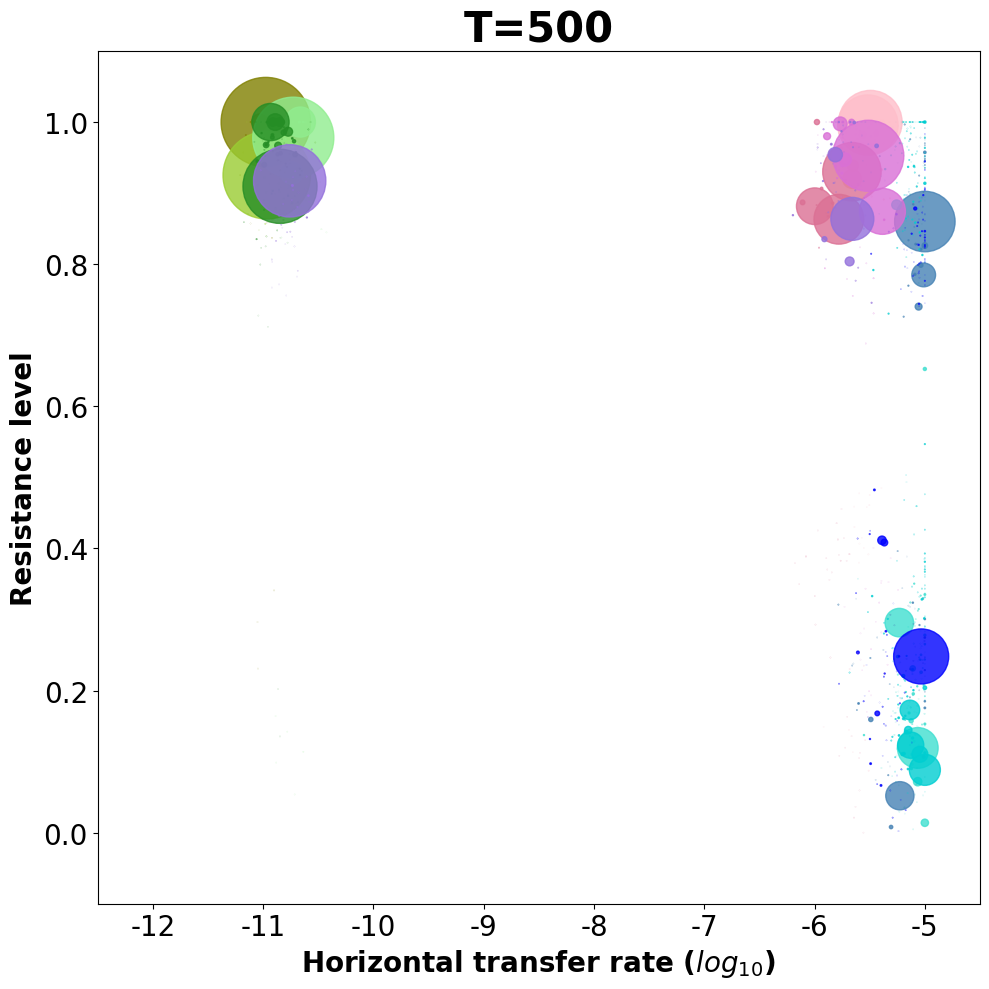

In [15]:
xticks=np.arange(-12,-4,1)
yticks=np.round(np.arange(0,1.1,0.2),1)
color=LinearSegmentedColormap.from_list("",["olive","yellowgreen","lightgreen","forestgreen","turquoise","steelblue","darkturquoise","blue","pink","palevioletred","orchid","mediumpurple"])
nb_mges_final=np.shape(B)[1]-1

norm=200
run=np.repeat(np.arange(1,nb_community+1),nb_mges_final)
a_tot=np.log10(np.tile(a_res,nb_community))
s_tot=np.tile(s_res[1:],nb_community)
mge_1d=np.reshape(B[:,1:],-1,order='C')

res={'run':run,'a_tot':a_tot,'s_tot':s_tot,'density_final':mge_1d/norm}
res_df = pd.DataFrame(data=res)

############################## FIGURES
fig, axs = plt.subplots(1,1,figsize=(10,10),sharex=True,sharey=True)

scatter=axs.scatter(data=res_df, x="a_tot", y="s_tot", s="density_final",c="run",cmap=color,alpha=0.8)
axs.set_xlabel("Horizontal transfer rate ($log_{10}$)",size=20,weight="bold")
axs.set_ylabel("Resistance level", size=20,weight="bold")
axs.set_title("T=500",size=30,weight="bold")

axs.set_xlim(-12.5,-4.5)
axs.set_ylim(-0.1,1.1)
axs.set_xticks(xticks)
axs.set_xticklabels(xticks,rotation=0,size=20)
axs.set_yticks(yticks)
axs.set_yticklabels(yticks,rotation=0,size=20)

legend1 = axs.legend(*scatter.legend_elements(num=nb_community),loc="lower left", title="Communities",fontsize=15,title_fontsize=15,bbox_to_anchor=(1.02, 0.15))
axs.add_artist(legend1)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

### t=1.000

In [16]:
T=1000-500
a=a_res
s_bis=s_res
r=R_fun(s_bis[1:],1)
r_bis=np.concatenate(([1],r))
e=e_log(a,1)

B0=B

B,a_res,s_res=mges_incompatibles_stochastique(B0,dt,T,nb_community,r_bis,e,d,a,s_bis,1e-4,g)
print(np.shape(B))

(12, 1450)


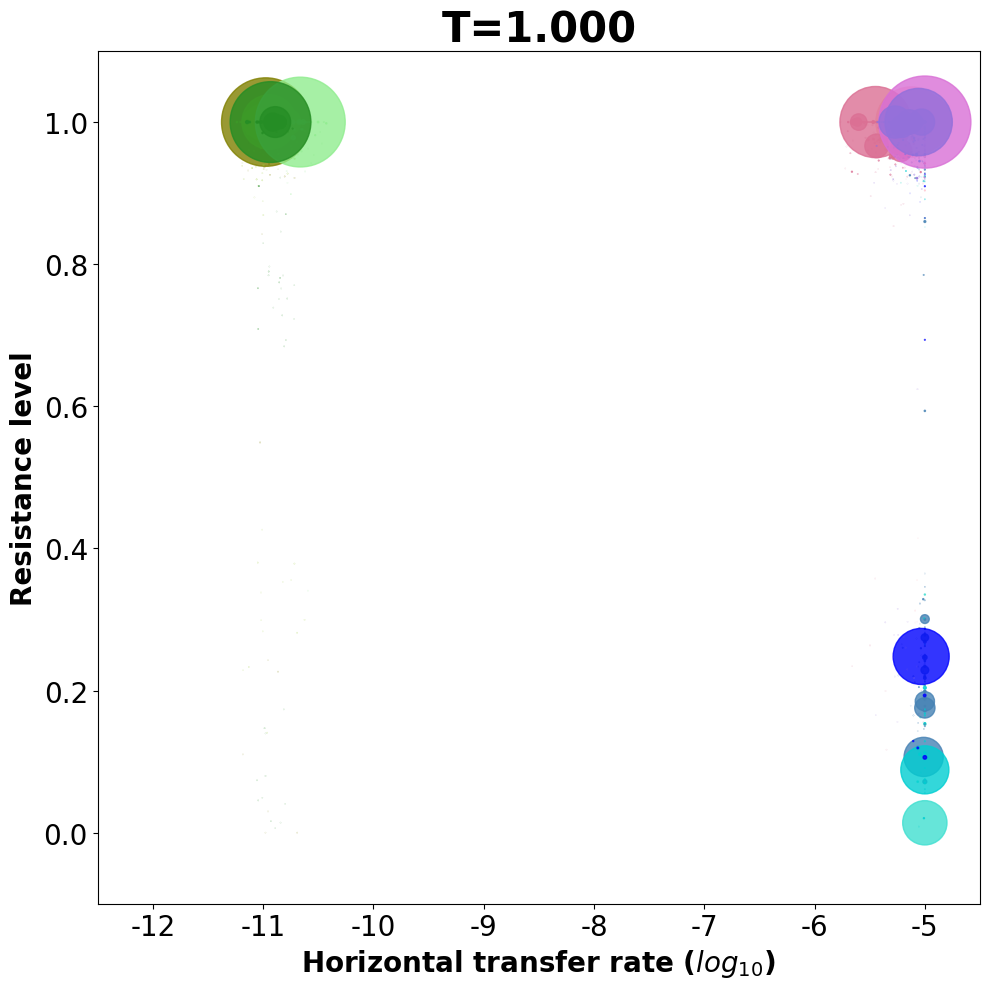

In [17]:
xticks=np.arange(-12,-4,1)
yticks=np.round(np.arange(0,1.1,0.2),1)
color=LinearSegmentedColormap.from_list("",["olive","yellowgreen","lightgreen","forestgreen","turquoise","steelblue","darkturquoise","blue","pink","palevioletred","orchid","mediumpurple"])
nb_mges_final=np.shape(B)[1]-1

norm=200
run=np.repeat(np.arange(1,nb_community+1),nb_mges_final)
a_tot=np.log10(np.tile(a_res,nb_community))
s_tot=np.tile(s_res[1:],nb_community)
mge_1d=np.reshape(B[:,1:],-1,order='C')

res={'run':run,'a_tot':a_tot,'s_tot':s_tot,'density_final':mge_1d/norm}
res_df = pd.DataFrame(data=res)

############################## FIGURES
fig, axs = plt.subplots(1,1,figsize=(10,10),sharex=True,sharey=True)

scatter=axs.scatter(data=res_df, x="a_tot", y="s_tot", s="density_final",c="run",cmap=color,alpha=0.8)
axs.set_xlabel("Horizontal transfer rate ($log_{10}$)",size=20,weight="bold")
axs.set_ylabel("Resistance level", size=20,weight="bold")
axs.set_title("T=1.000",size=30,weight="bold")

axs.set_xlim(-12.5,-4.5)
axs.set_ylim(-0.1,1.1)
axs.set_xticks(xticks)
axs.set_xticklabels(xticks,rotation=0,size=20)
axs.set_yticks(yticks)
axs.set_yticklabels(yticks,rotation=0,size=20)

legend1 = axs.legend(*scatter.legend_elements(num=nb_community),loc="lower left", title="Communities",fontsize=15,title_fontsize=15,bbox_to_anchor=(1.02, 0.15))
axs.add_artist(legend1)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## LEGEND

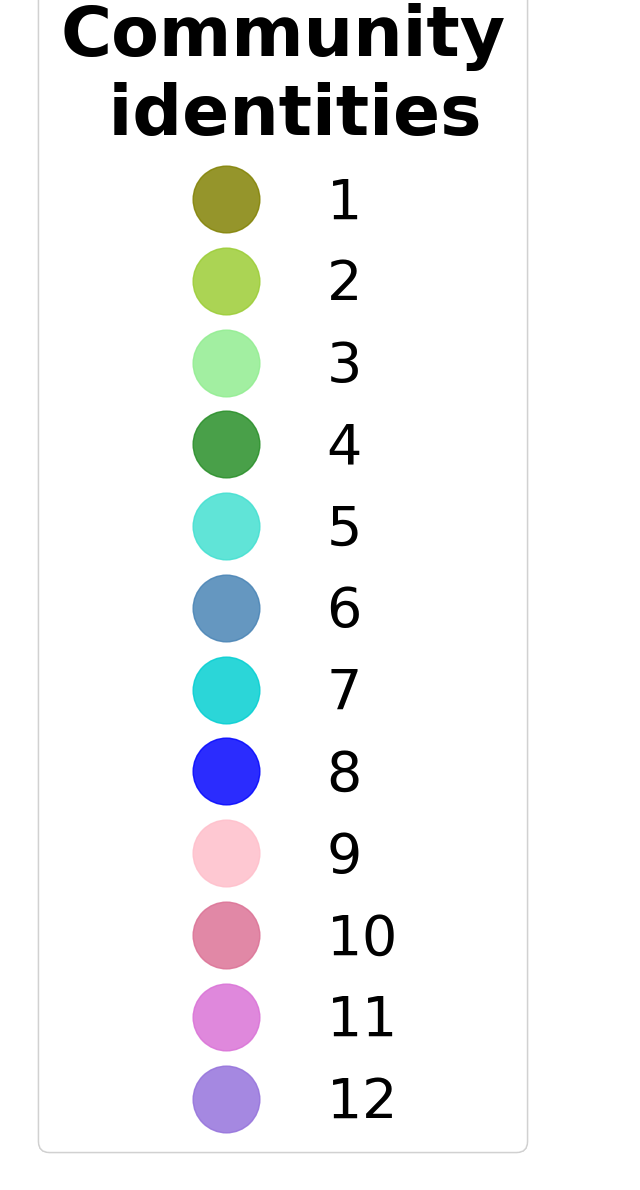

In [21]:
############################## FIGURES
fig, axs = plt.subplots(1,1,figsize=(6.5,12),sharex=True,sharey=True)
scatter=axs.scatter(data=res_df, x="a_tot", y="s_tot", s="density_final",c="run",cmap=color,alpha=0.8)

axs.set_axis_off()  
for coll in axs.collections:
    coll.remove()
axs.set_frame_on(False)  # Enlève la boîte autour du plot
legend1 = axs.legend(*scatter.legend_elements(num=nb_community),loc="lower left", title="Community\n  identities",markerscale=8, 
                     fontsize=40,title_fontproperties={'size':50,'weight':'bold'},bbox_to_anchor=(0, 0))
axs.add_artist(legend1)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## RANK ABUNDANCE DISTRIBUTIONS

In [22]:
data_plasmid_1=pd.read_csv('observed_data/PTU_count.tsv',sep='\t')

In [23]:
repertory='simulated_data/unified_model_sensibility_analysis/dispersion=1e-09_innovation=0.0001/'

In [29]:
nb_replicats=25
plasmids_abundances_tot=np.zeros((nb_replicats,2000))
for i in range(nb_replicats):
    B = np.loadtxt(repertory+'simulation_'+str(i)+".csv", delimiter=',')
    B=B[:12,1:]
    nb_mges_final=np.shape(B)[1]
    nb_community=np.shape(B)[0]
    proba=B/np.sum(B,1).reshape((nb_community,-1))
    taille_effectif=np.random.multinomial(4411,np.sum(B,1)/np.sum(B))
    B_echantillon=np.zeros(nb_mges_final)
    for j in range(nb_community):
        B_echantillon=B_echantillon+np.random.multinomial(taille_effectif[j],proba[j])
    res=np.flip(np.sort(B_echantillon))
    ## stockage
    plasmids_abundances_tot[i,:nb_mges_final]=res

In [30]:
median_plasmids_abundances_tot=np.quantile(plasmids_abundances_tot,0.5,axis=0)
median_number=np.sum(median_plasmids_abundances_tot>0)

In [35]:
Q1_plasmids_abundances_tot=np.log10(np.quantile(plasmids_abundances_tot,0.25,axis=0))
Q1_plasmids_abundances_tot[Q1_plasmids_abundances_tot==-np.inf]=-1000
Q1_plasmids_abundances_tot[median_number:]=np.nan
    
Q3_plasmids_abundances_tot=np.log10(np.quantile(plasmids_abundances_tot,0.75,axis=0))
Q3_plasmids_abundances_tot[Q3_plasmids_abundances_tot==-np.inf]=-1000

/tmp/ipykernel_13488/705222100.py:1: RuntimeWarning: divide by zero encountered in log10
  Q1_plasmids_abundances_tot=np.log10(np.quantile(plasmids_abundances_tot,0.25,axis=0))
/tmp/ipykernel_13488/705222100.py:5: RuntimeWarning: divide by zero encountered in log10
  Q3_plasmids_abundances_tot=np.log10(np.quantile(plasmids_abundances_tot,0.75,axis=0))


/tmp/ipykernel_13488/3617326775.py:5: RuntimeWarning: divide by zero encountered in log10
  axs.plot(np.arange(1,2000+1),np.log10(median_plasmids_abundances_tot),color="tab:gray",label="Metacommunity",linewidth=4)


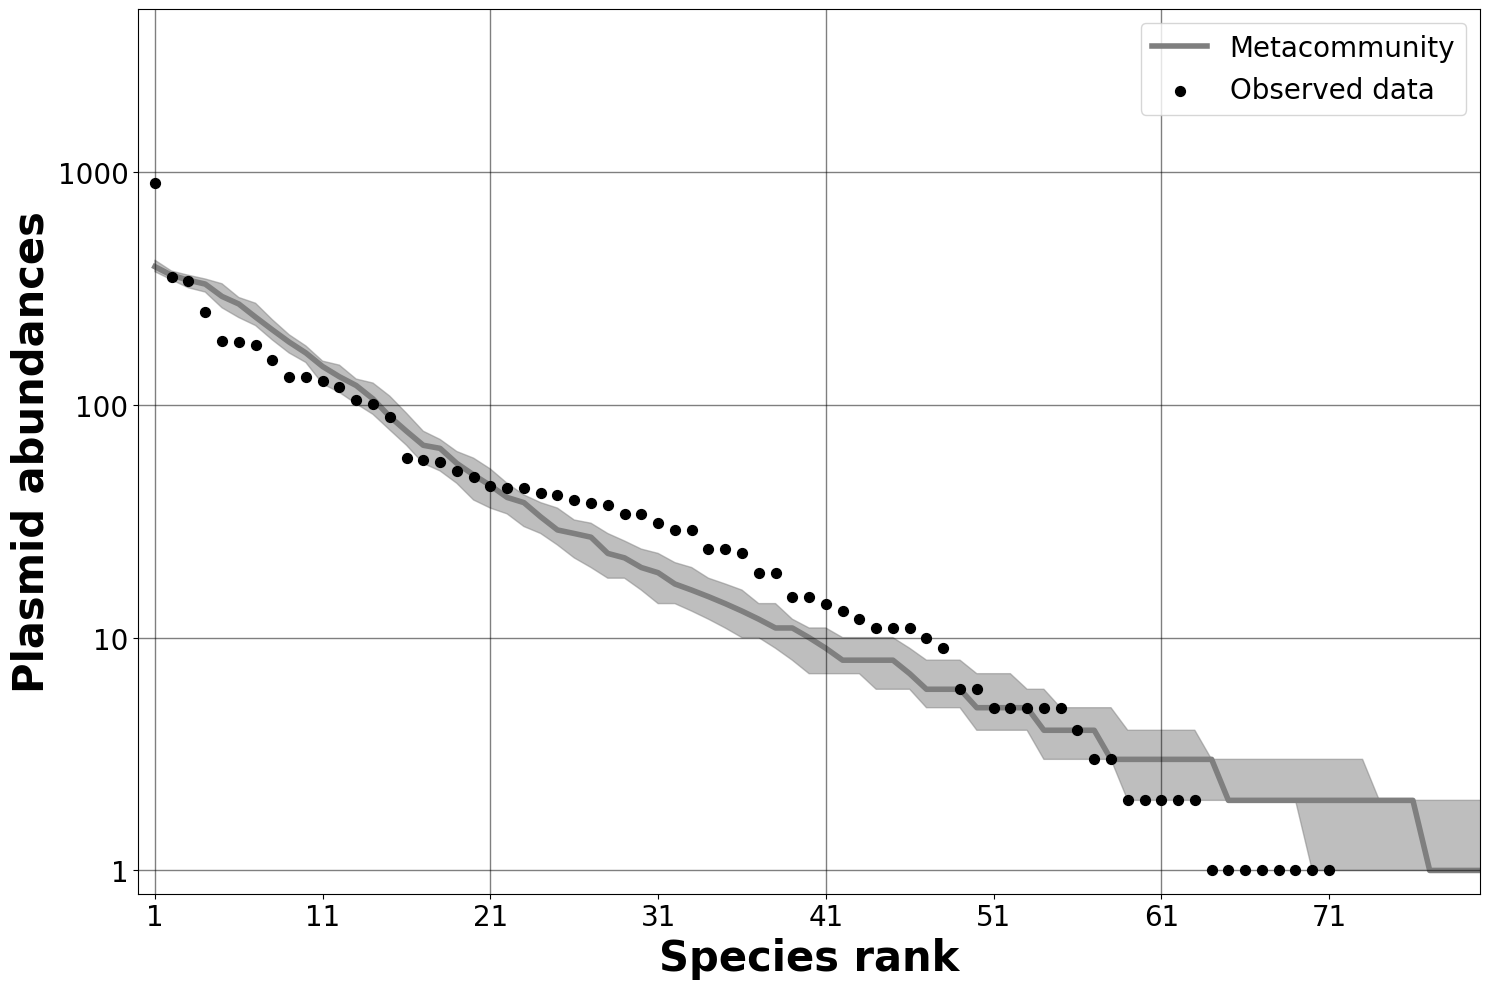

In [38]:
transparence=0.5
nb_plasmides=np.shape(data_plasmid_1)[0]

fig, axs= plt.subplots(1,1,figsize=(15,10),sharex=True)
axs.plot(np.arange(1,2000+1),np.log10(median_plasmids_abundances_tot),color="tab:gray",label="Metacommunity",linewidth=4)
axs.fill_between(np.arange(1,2000+1), Q1_plasmids_abundances_tot, Q3_plasmids_abundances_tot,color="tab:gray",linewidth=1,alpha=0.5)

axs.scatter(np.arange(1,nb_plasmides+1),np.log10(np.flip(np.sort(data_plasmid_1['count']))),alpha=1,color='black',s=50,label="Observed data",zorder=4)
axs.set_ylabel('Plasmid abundances',size=30,weight="bold")
axs.set_xlabel('Species rank',size=30,weight="bold")
axs.set_xticks(ticks=np.arange(1,1000,10))
axs.set_yticks(ticks=[0,1,2,3,4]) 
axs.set_yticklabels(labels=[1,10,100,1000,10000])
axs.tick_params(axis='both', labelsize=20)
axs.plot([-10, 1000], [4, 4],color="black",linewidth=1,alpha=transparence)
axs.plot([-10, 1000], [3, 3],color="black",linewidth=1,alpha=transparence)
axs.plot([-10, 1000], [2, 2],color="black",linewidth=1,alpha=transparence)
axs.plot([-10, 1000], [1, 1],color="black",linewidth=1,alpha=transparence)
axs.plot([-10, 1000], [0, 0],color="black",linewidth=1,alpha=transparence)

axs.plot([1, 1], [-1, 5],color="black",linewidth=1,alpha=transparence)
axs.plot([21, 21], [-1, 5],color="black",linewidth=1,alpha=transparence)
axs.plot([41, 41], [-1, 5],color="black",linewidth=1,alpha=transparence)
axs.plot([61, 61], [-1, 5],color="black",linewidth=1,alpha=transparence)
axs.plot([81, 81], [-1, 5],color="black",linewidth=1,alpha=transparence)
axs.set_xlim(0,80)
axs.set_ylim(-0.1,3.7)
axs.legend(loc='upper right',fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()